**Defining the objective**


The aim of this project is to create a Speech-To-Text application using an ASR (Automatic Speech Recognition) system, Whisper. 

Whisper has been trained for 680,000 hours on huge amount of speech data collected from the internet. The diverse dataset allows Whisper to understand different accents, and filter background noise. The Whisper architecture is a simple end-to-end approach, implemented as an encoder-decoder Transformer. Input audio is split into 30-second chunks, converted into a log-Mel spectrogram, and then passed into an encoder. A decoder is trained to predict the corresponding text caption, intermixed with special tokens that direct the single model to perform tasks such as language identification, phrase-level timestamps, multilingual speech transcription, and to-English speech translation.

 You can learn more about Whisper from https://openai.com/blog/whisper/

**Installing Required Libraries**

In [1]:
!pip install --upgrade torch
!pip install pytube
!pip install git+https://github.com/openai/whisper.git
!pip install git+https://github.com/librosa/librosa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 698.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 29.6 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cpu
    Uninstalling torch-1.11.0+cpu:
      Successfully uninstalled torch-1.11.0+cpu
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cpu requires torch==1.11.0, but you have torch 1.13.1 which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.13.1 which is incompatible.
torchaudio 0.11.0+cpu requires torch==1.11.0, but you have torch 1.13.1

In [2]:
#Importing the necessary libraries
import torch
import whisper
import pytube
import librosa
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd

**Please note:** If you don't already have those libraries installed, trying to import them would not work as they have to be installed first. 

**Loading the Model**

There are five model sizes to choose from, four have English-only versions, offering speed and accuracy trade-offs. The model sizes are:
- tiny: 39M Parameters, English-only model (tiny.en), Multilingual model (tiny), Required VRAM (1GB), Relative speed (32x)
- base: 74M Parameters, English-only model (base.en), Multilingual model (base), Required VRAM (1GB), Relative speed (16x)
- small: 244M Parameters, English-only model (small.en), Multilingual model (small), Required VRAM (2GB), Relative speed (6x)
- medium: 769M Parameters, English-only model (medium.en), Multilingual model (medium), Required VRAM (5GB), Relative speed (2x)
- tiny: 1550M Parameters, English-only model (N/A), Multilingual model (large), Required VRAM (10GB), Relative speed (1x)
The tiny model can be utilized best for light weight applications, the large model if accuracy is most important, and the base, small or medium models for everything in between. For this project, we would be using the medium model.

In [3]:
model_m = whisper.load_model('medium')

100%|█████████████████████████████████████| 1.42G/1.42G [00:25<00:00, 61.1MiB/s]


**Loading the file**

We start by loading an audio file.

In [4]:
file_path = '/kaggle/input/voice-recording/Record (online-voice-recorder.com).mp3'

I created a custom voice recording of myself, in file_path above to use for this project. Next we're going to load the audio file in file_path using the load_audio() function.

In [5]:
#Loading
audio_13 = whisper.load_audio(file_path)
audio_13

array([0.        , 0.        , 0.        , ..., 0.0007019 , 0.00064087,
       0.00045776], dtype=float32)

Next, we find the sampling interval. The sampling interval is the distance or time between the measurements. The total time of audio is 13 seconds.

In [6]:
T = 13

In [7]:
#Checking the number of samples in our audio file
n_samples =  audio_13.shape[0]
n_samples

200448

There are 200448 number of samples in 13 seconds audio. Now we find the time between samples.

In [8]:
#Time between samples
delta = T/n_samples
delta

6.485472541507024e-05

The time between samples is 6.485472541507024e-05. Next, we find the sampling frequency.

In [9]:
#Sampling frequency
Fs = 1/delta
Fs

15419.076923076924

The sampling frequency is 15419.076923076924. Next, we find the time of each sample.

In [10]:
#Time of each sample
time = np.linspace(0,(n_samples-1) * delta,n_samples)
time

array([0.00000000e+00, 6.48547254e-05, 1.29709451e-04, ...,
       1.29998054e+01, 1.29998703e+01, 1.29999351e+01])

Now we plot the amplitude with respect to time:

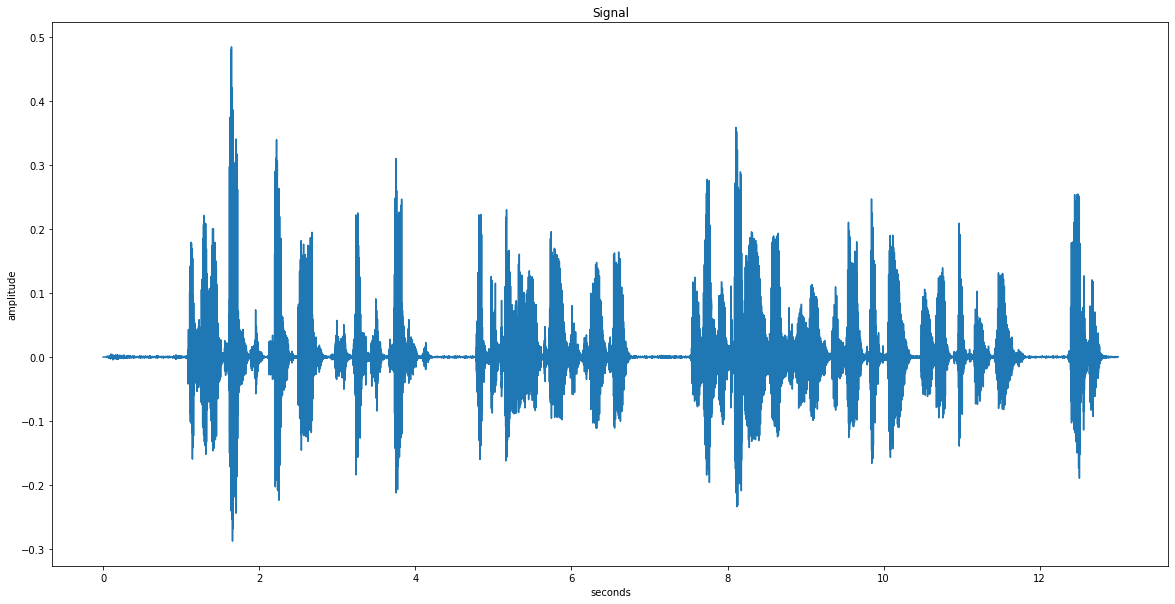

In [11]:
plt.figure(figsize=(20,10))
plt.title('Signal')
plt.plot(time,audio_13)
plt.ylabel('amplitude')
plt.xlabel('seconds')
plt.show()

Above is a waveform for the signal. Now, we can use the pad_or_trim() method to ensure the sample is in the right form for inference.

In [12]:
audio = whisper.pad_or_trim(audio_13)

Next, we plot the amplitude with respect to time with trimmed/padded audio.

In [13]:
#Number of samples in our trimmed/padded audio
n_samples =  audio.shape[-1]
#Time of each sample
time = np.linspace(0,(n_samples-1)*delta,n_samples)

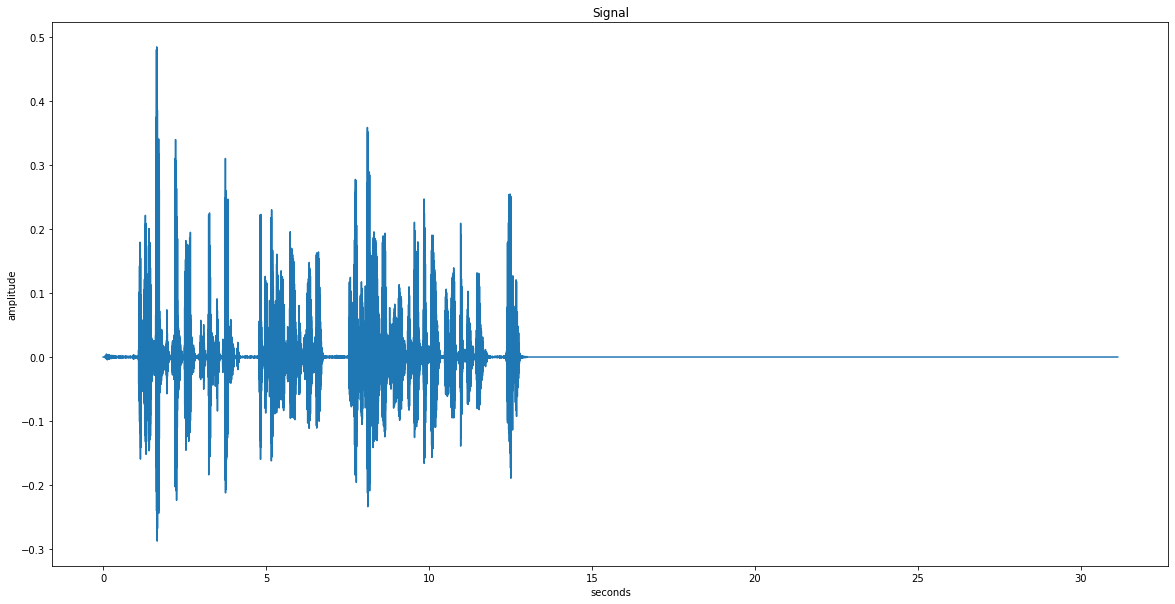

In [14]:
plt.figure(figsize=(20,10))
plt.title('Signal')
plt.plot(time,audio)
plt.ylabel('amplitude')
plt.xlabel('seconds')
plt.show()

Next, we can start plotting a mel spectogram by applying a log_mel_spectogram() funtion to our audio file. It converts the y-axis (frequency) into the mel scale:

In [15]:
mel = whisper.log_mel_spectrogram(audio).to(model_m.device)

The output above is a tensor of converted frequencies. Now, we plot 2 subplots, one is a regular representation of sound amplitude over period of time, and the other is our mel spectrogram:

Text(20.75, 0.5, 'Mel Scale')

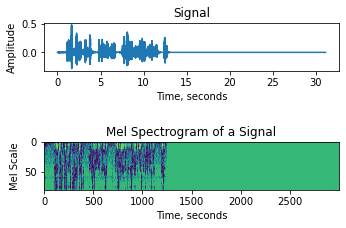

In [16]:
fig, (ax1, ax2) = plt.subplots(2)
fig.tight_layout(pad=5.0)
ax1.plot(time,audio)
ax1.set_title('Signal')
ax1.set_xlabel('Time, seconds')
ax1.set_ylabel('Amplitude')
ax2.imshow((mel.numpy()*mel.numpy())**(1/2),interpolation='nearest', aspect='auto')
ax2.set_title('Mel Spectrogram of a Signal')
ax2.set_xlabel('Time, seconds')
ax2.set_ylabel('Mel Scale')

Next, we can move on to language detection.

**Language detection**

We will listen to our audio file and detect the spoken language. The sample rate (sr) by default is 22050, which means that for every second there are 22,050 samples. We can use ipd.Audio() function to listen to our audio file.

In [17]:
sr=22050
ipd.Audio(audio, rate=sr)

Next, We can obntain the probability of each language by using detect_language() method.

In [18]:
probs = model_m.detect_language(mel)

In [19]:
probs

(tensor(50259),
 {'en': 0.9849050641059875,
  'zh': 1.5219412716760417e-06,
  'de': 3.6501831345958635e-05,
  'es': 0.00021514804393518716,
  'ru': 1.0518123417568859e-05,
  'ko': 4.984785846318118e-05,
  'fr': 0.0012794482754543424,
  'ja': 2.1116293282830156e-05,
  'pt': 3.835697498288937e-05,
  'tr': 5.9751062508439645e-05,
  'pl': 1.4921065485395957e-05,
  'ca': 8.167675247250372e-08,
  'nl': 1.606777004781179e-05,
  'ar': 0.00014307477977126837,
  'sv': 5.288614920573309e-05,
  'it': 3.9235812437254936e-05,
  'id': 0.00012587445962708443,
  'hi': 2.1956673663225956e-05,
  'fi': 1.3050894267507829e-06,
  'vi': 5.847105626344273e-07,
  'he': 0.0001297963608521968,
  'uk': 2.0154755020485027e-06,
  'el': 1.0030913472292013e-05,
  'ms': 0.00018149794777855277,
  'cs': 3.48104331351351e-05,
  'ro': 1.4391631339094602e-05,
  'da': 1.2410632166393043e-07,
  'hu': 1.734098987071775e-05,
  'ta': 5.0501309800665695e-08,
  'no': 1.3199689874454634e-07,
  'th': 2.3375656382995658e-05,
  'ur':

From above, we can see the probability of each language being the spoken language. English has the highest probability of 98.5%, therefore it is the spoken language in the audio file.

Next, we can move on to transcription.

**Transcription**

In [20]:
transcription = model_m.transcribe(file_path, fp16 = False)['text']

In [21]:
transcription

" This is a test to test out the speech to text application I'm currently creating. And this recording is going to be used for that purpose and that purpose only. Thank you."

From the transcription above, we can see our Speech-To-Text system works very well, it transcribed our audio perfectly.

As an adition, we can translate our audio file to another language.

**Translation**

We would translate our audio file to Spanish, by setting language='es'.

In [22]:
translation = model_m.transcribe(file_path, language = 'es', fp16 = False)['text']

In [23]:
translation

' Este es un test para testar la aplicación que estoy creando ahora. Este recorrido será usado para ese propósito y solo para ese propósito. Gracias.'

Our audio file can be translated to other languages as well.

**Conclusion**

We have been able to create a Speech-To-Text application using an ASR (Automatic Speech Recognition) system, Whisper. Speech-To-Text has a variety of use cases which include transcribing audio recordings, dictation, voice commands, online search, enhanced customer service etc.